In [3]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
import scipy as sp
%matplotlib inline

import torch
from torch.optim import Adam
from deepseries.nn.loss import MSELoss, RMSELoss

from deepseries.models import Wave2WaveV1
from deepseries.train import Learner
from deepseries.dataset import TimeSeries, Property, Seq2SeqDataLoader
from deepseries.optim import ReduceCosineAnnealingLR

In [4]:
DIR = "../data"
N_ROWS = 40000
BATCH_SIZE = 32


LAGS = [365]
MAX_LAGS = max(LAGS)
DROP_BEFORE = 1000

SEQ_LAST = True
ENC_LEN = 366
DEC_LEN = 28

VALID_LEN = 28
TEST_LEN = 28

TRAIN_LAST_DAY = 1913
USE_SERIES_LEN = TRAIN_LAST_DAY - DROP_BEFORE + 1 + 28

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "int16", 'snap_TX': 'int16', 'snap_WI': 'int16' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [5]:
def load_data():
    label_encoders = {}
    
    prices = pd.read_csv(os.path.join(DIR, "sell_prices.csv"), dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(prices[col].astype(str).fillna("None"))
            prices[col] = label_encoders[col].transform(prices[col].astype(str).fillna("None")).astype("int16")
    
    cal = pd.read_csv(os.path.join(DIR, "calendar.csv"), dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(cal[col].astype(str).fillna("None"))
            cal[col] = label_encoders[col].transform(cal[col].astype(str).fillna("None")).astype("int16")
    
    numcols = [f"d_{day}" for day in range(DROP_BEFORE, TRAIN_LAST_DAY+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(os.path.join(DIR, "sales_train_validation.csv"), 
                     usecols = catcols + numcols, dtype = dtype, nrows=N_ROWS)
    
    for col in catcols:
        if col != "id":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(dt[col].astype(str).fillna("None"))
            dt[col] = label_encoders[col].transform(dt[col].astype(str).fillna("None")).astype("int16")

    for day in range(TRAIN_LAST_DAY+1, TRAIN_LAST_DAY+28+1):
        dt[f"d_{day}"] = np.nan
    
    product = dt[catcols].copy()
    print(f"product shape {product.shape}")

    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

    dt = dt.merge(cal[['d', 'wm_yr_wk']], on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    dt['d'] = dt['d'].str.replace('d_', '').astype("int32")
    price = dt.pivot(index="id", columns="d", values="sell_price")
    xy = dt.pivot(index="id", columns="d", values="sales")
    del dt; gc.collect()
    print(f"sale_xy shape {xy.shape}")
    print(f"price shape {price.shape}")

    cal_use_col = ['date', 'wday', 'month', 'year', 'event_name_1',
    'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
    'snap_WI']
    cal = cal[cal_use_col]
    cal['year'] = cal['year'] - cal['year'].min()
    cal['quarter'] = cal.date.dt.quarter
    cal = cal.drop("date", axis=1).T
    cal = cal[xy.columns]
    print(f"calendar shape {cal.shape}")
    
    submission = pd.read_csv(os.path.join(DIR, "sample_submission.csv"))
    print(f"submisson shape {submission.shape}")
    return xy, price, cal, product, submission

df_series, df_price, df_calendar, df_product, df_sub = load_data()

product shape (30490, 6)
sale_xy shape (30490, 942)
price shape (30490, 942)
calendar shape (11, 942)
submisson shape (60980, 29)


In [7]:
# series
series = np.log1p(df_series.values)
price = np.log1p(df_price.values)

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  
/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# series state
series_nan = np.isnan(series).astype("int8")
series_zero = (series == 0).astype("int8")

In [9]:
# series statistics

series_valid_masked = np.ma.masked_array(series, mask=series_nan.astype(bool))

series_mean = series_valid_masked[:, MAX_LAGS:].mean(axis=1).data
series_std = series_valid_masked[:, MAX_LAGS:].std(axis=1).data
series_skew = sp.stats.mstats.skew(series_valid_masked[:, MAX_LAGS:], axis=1).data
series_kurt = np.clip(sp.stats.mstats.kurtosis(series_valid_masked[:, MAX_LAGS:], axis=1).data, None, 10)

In [10]:
# series center

series = np.nan_to_num((series - np.expand_dims(series_mean, 1)), 0.).astype("float32")

In [11]:
# series lag

def make_lags(x, n, smooth=True):
    lag = np.zeros_like(x)
    lag[:, n:] = x[:, :-n]
    if smooth:
        lag_left = np.zeros_like(x)
        lag_right = np.zeros_like(x)
        lag_left[:, n-1:] = x[:, :-n+1]
        lag_right[:, n+1:] = x[:, :-n-1]
        lag = lag * 0.5 + lag_left * .25 + lag_right * .25
        lag[:, :n] = 0
    return lag

lags = np.stack([make_lags(series, l) for l in LAGS], 1)[:, :, MAX_LAGS:]
series = np.expand_dims(series[:, MAX_LAGS:], 1)

In [12]:
# series statistic features

series_mean_mean = series_mean.mean()
series_mean_std = series_mean.std()
series_std_mean = series_std.mean()
series_std_std = series_std.std()
series_skew_mean = series_skew.mean()
series_skew_std = series_skew.std()
series_kurt_mean = series_kurt.mean()
series_kurt_std = series_kurt.std()

xy_series_mean = (series_mean - series_mean_mean)
xy_series_std = (series_std - series_std_mean)
xy_series_skew = (series_skew - series_skew_mean)
xy_series_kurt = (series_kurt - series_kurt_mean)

xy_series_stats = np.stack([xy_series_mean, xy_series_std, xy_series_skew, xy_series_kurt], axis=1)
x_series_label = np.stack([series_nan, series_zero], axis=1)[:, :, MAX_LAGS:]

In [13]:
# series categorical features

xy_series_cat = df_product.set_index("id").values.astype("int64")

In [14]:
# calendar feature

def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)

xy_calendar_embed = np.concatenate([
    periodic_feature(df_calendar.T['wday'].values, 7),
    periodic_feature(df_calendar.T['month'].values, 12),
    periodic_feature(df_calendar.T['quarter'].values, 4),
    df_calendar.T[['snap_CA', 'snap_TX', 'snap_WI']].values.T
])
xy_calendar_embed = np.expand_dims(xy_calendar_embed, 0)[:, :, MAX_LAGS:]

xy_event_type = np.expand_dims(
    df_calendar.T[['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']].T.values, 0)[:, :, MAX_LAGS:]

In [15]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()

train_idx, valid_idx = spliter.split(np.arange(series.shape[2]), ENC_LEN, DEC_LEN, VALID_LEN+TEST_LEN)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, TEST_LEN)

In [16]:
for i in [series, lags, xy_series_stats, x_series_label, xy_series_cat, xy_event_type, xy_calendar_embed]:
    print(i.shape)

(30490, 1, 577)
(30490, 1, 577)
(30490, 4)
(30490, 2, 577)
(30490, 5)
(1, 4, 577)
(1, 9, 577)


In [17]:
train_series = TimeSeries(series[:, :, train_idx])
valid_series = TimeSeries(series[:, :, valid_idx])
test_series = TimeSeries(series[:, :, test_idx])

train_lag = TimeSeries(lags[:, :, train_idx])
valid_lag = TimeSeries(lags[:, :, valid_idx])
test_lag = TimeSeries(lags[:, :, test_idx])

train_xy_series_stats = Property(xy_series_stats)
valid_xy_series_stats = Property(xy_series_stats)
test_xy_series_stats = Property(xy_series_stats)

train_x_series_label = TimeSeries(x_series_label[: ,: ,train_idx])
valid_x_series_label = TimeSeries(x_series_label[:, :, valid_idx])
test_x_series_label = TimeSeries(x_series_label[:, :, test_idx])

train_xy_cat = Property(xy_series_cat)
valid_xy_cat = Property(xy_series_cat)
test_xy_cat = Property(xy_series_cat)

N_ROWS = df_series.shape[0]

train_xy_event = TimeSeries(xy_event_type[:, :, train_idx], idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))
valid_xy_event = TimeSeries(xy_event_type[:, :, valid_idx], idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))
test_xy_event = TimeSeries(xy_event_type[:, :, test_idx], idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))

train_xy_calendar_embed = TimeSeries(xy_calendar_embed[:, :, train_idx], idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))
valid_xy_calendar_embed = TimeSeries(xy_calendar_embed[:, :, valid_idx], idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))
test_xy_calendar_embed = TimeSeries(xy_calendar_embed[:, :, test_idx], idx_map=dict(zip(np.arange(N_ROWS), [0] * N_ROWS)))

In [18]:
weights = 1 - np.expand_dims(series_nan[:, MAX_LAGS:], axis=1)
train_weights = TimeSeries(weights[:, :, train_idx])
valid_weights = TimeSeries(weights[:, :, valid_idx])

In [19]:
train_dl = Seq2SeqDataLoader(train_series, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='train', 
                             time_free_space=10,
                             enc_num_feats=[train_lag, train_xy_series_stats, train_x_series_label, train_xy_calendar_embed], 
                             enc_cat_feats=[train_xy_cat, train_xy_event], 
                             dec_num_feats=[train_lag, train_xy_series_stats, train_xy_calendar_embed], 
                             dec_cat_feats=[train_xy_cat, train_xy_event],
                             seq_last=SEQ_LAST,
                             weights=train_weights,
                            )

valid_dl = Seq2SeqDataLoader(valid_series, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='valid', 
                             time_free_space=0,
                             enc_num_feats=[valid_lag, valid_xy_series_stats, valid_x_series_label, valid_xy_calendar_embed], 
                             enc_cat_feats=[valid_xy_cat, valid_xy_event], 
                             dec_num_feats=[valid_lag, valid_xy_series_stats, valid_xy_calendar_embed],
                             dec_cat_feats=[valid_xy_cat, valid_xy_event], 
                             seq_last=SEQ_LAST,
                             weights=valid_weights
                              )

test_dl = Seq2SeqDataLoader(test_series, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='test', 
                             time_free_space=0,
                             enc_num_feats=[test_lag, test_xy_series_stats, test_x_series_label, test_xy_calendar_embed], 
                             enc_cat_feats=[test_xy_cat, test_xy_event], 
                             dec_num_feats=[test_lag, test_xy_series_stats, test_xy_calendar_embed],
                             dec_cat_feats=[test_xy_cat, test_xy_event], 
                            seq_last=SEQ_LAST,
                      )

In [37]:
model = Wave2WaveV1(enc_num=16,
    enc_cat=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1), (32, 4), (5, 1), (5, 1), (3, 1)],
                dec_num=14,
                dec_cat=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1), (32, 4), (5, 1), (5, 1), (3, 1)],
                dropout=0.0,
                    hidden_size=512,
                    n_layers=10,
                    n_blocks=2,
                   )
opt = Adam(model.parameters(), 0.001)
loss_fn = RMSELoss()
lr_scheduler = ReduceCosineAnnealingLR(opt, 64, eta_min=1e-4, gamma=0.998)
model.cuda()
learner = Learner(model, opt, loss_fn, './m5_rnn', verbose=-1, lr_scheduler=None)
learner.fit(50, train_dl, valid_dl, patient=64, start_save=100, early_stopping=False)

[[04/24/2020 00:09:22]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./m5_rnn/logs
[[04/24/2020 00:19:49]] epoch 5 / 54, batch 100%, train loss 0.4823, valid loss 0.4843, cost 10.5 min
[[04/24/2020 00:29:04]] epoch 6 / 54, batch 100%, train loss 0.4806, valid loss 0.4870, cost 9.3 min
[[04/24/2020 00:41:38]] epoch 7 / 54, batch 100%, train loss 0.4793, valid loss 0.4833, cost 12.6 min
[[04/24/2020 00:58:18]] epoch 8 / 54, batch 100%, train loss 0.4753, valid loss 0.4826, cost 16.7 min
[[04/24/2020 01:13:13]] epoch 9 / 54, batch 100%, train loss 0.4766, valid loss 0.4865, cost 14.9 min
[[04/24/2020 01:28:12]] epoch 10 / 54, batch 100%, train loss 0.4741, valid loss 0.4893, cost 15.0 min
[[04/24/2020 01:43:10]] epoch 11 / 54, batch 100%, train loss 0.4752, valid loss 0.4865, cost 15.0 min
[[04/24/2020 02:00:29]] epoch 12 / 54, batch 100%, train loss 0.4737, valid loss 0.4863, cost 17.3 min
[[04/24/2020 02:12:29]] epoch 13 / 54, batch 100%, train loss 0.4720, valid loss 0.486

KeyboardInterrupt: 

In [38]:
def predict_submission(model, test_dl):
    model.eval()
    test_dl.test()
    preds = []
    for batch in test_dl:
        preds.append(model.predict(**batch).cpu().detach().numpy())
    preds = np.concatenate(preds, axis=0).squeeze()
    preds = np.expm1(preds + np.expand_dims(series_mean, 1))
    return preds

preds = predict_submission(learner.model, test_dl)
top1 = pd.read_csv("../data/submission_top1.csv").iloc[:30490].set_index("id").loc[df_series.index]

def plot(idx):
    plt.figure(figsize=(16, 5))
    plt.plot(df_series.iloc[idx, -56:-28].values)
    plt.plot(np.arange(28, 56), preds[idx], label='wave')
    plt.plot(np.arange(28, 56), top1.iloc[idx, :].values, label='lgb')
    plt.title(f"enc {df_series.iloc[idx, -56:-28].values.mean():.2f} pred {preds[idx].mean():.2f}\
    top1 mean {top1.iloc[idx, 1:].values.mean():.2f}")
    plt.legend()

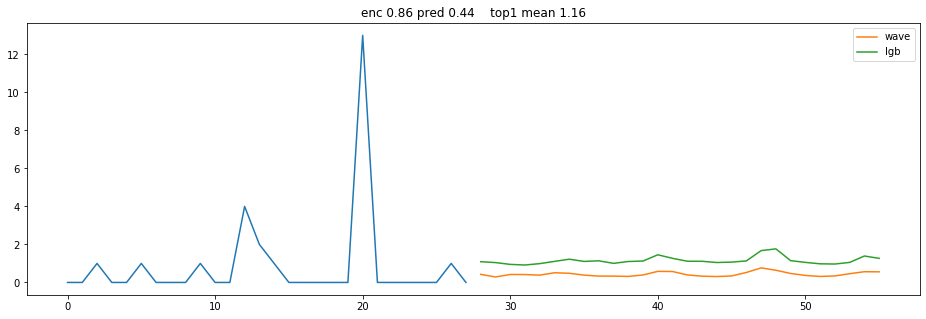

In [47]:
plot(2)

In [42]:
preds.mean()

0.9711737463056912

In [43]:
top1.mean().mean()

1.4331789663311454